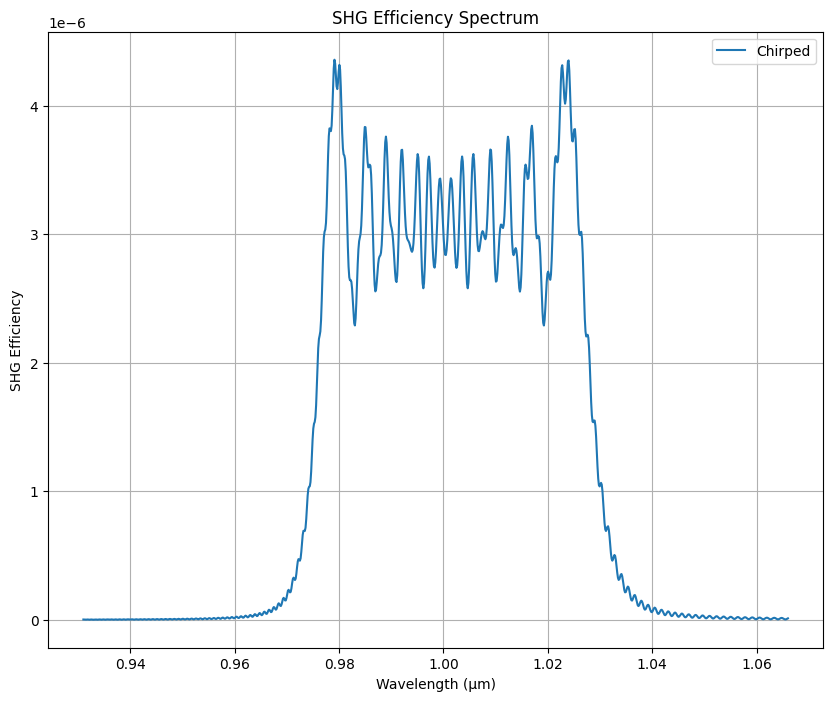

In [5]:
from syuron import shg
from syuron import mgoslt
from syuron import pp
import jax.numpy as jnp
import matplotlib.pyplot as plt


chirped_stack_dim = pp.chirped(600, [3.6], 1.031E-05, [0.0001])
random_stack_dim = pp.random(100, 101, 1.031E-05, 3.4, 3.6)
fixed_stack_dim = pp.fixed(300, [3.6], 1.031E-05)

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg.Params(
    domain_stack_dim=chirped_stack_dim,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
)

eff_tensor = mgoslt.analyze(params)

plt.figure(figsize=(10, 8))
plt.plot(wavelength_dim, eff_tensor[0, 0, :, 0, 0], label="Chirped")
plt.xlabel("Wavelength (μm)")
plt.ylabel("SHG Efficiency")
plt.title("SHG Efficiency Spectrum")
plt.legend()
plt.grid(True)
plt.show()

データセットの入力の作成完了
計算が終了


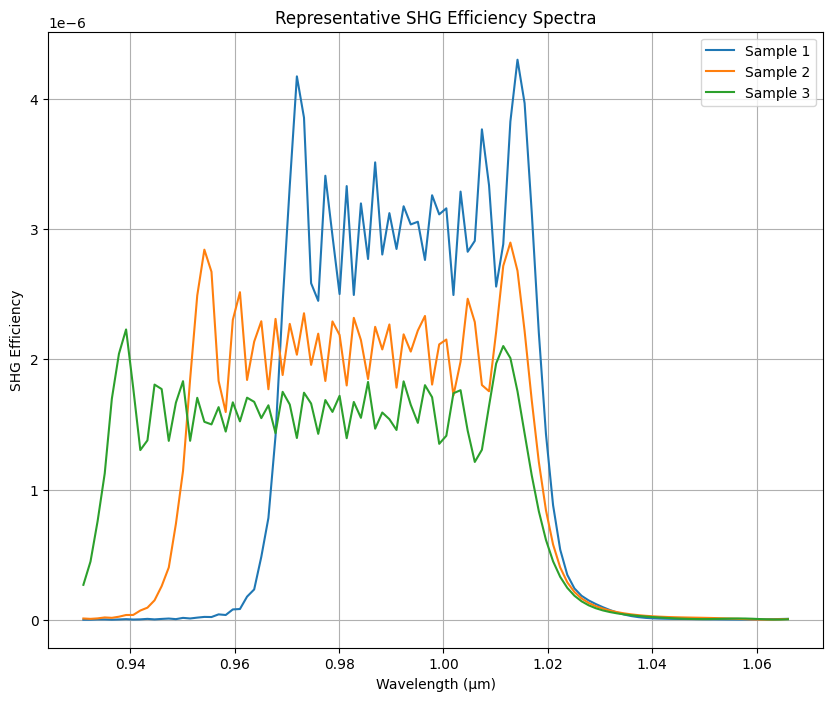

In [6]:
from syuron import shg
import jax.numpy as jnp
from syuron import pp
from syuron import mgoslt
import matplotlib.pyplot as plt
import json


num_start_width = 10
num_chirp_rate = 10
num_samples = num_chirp_rate * num_start_width
chirped_stack_dim = pp.chirped(600, jnp.linspace(
    3.5, 4, num_start_width).tolist(), 1.031E-05, jnp.linspace(0.0001, 0.0005, num_chirp_rate).tolist())

print("データセットの入力の作成完了")

wavelength_dim = jnp.linspace(0.931, 1.066, 100).tolist()

params = shg.Params(
    domain_stack_dim=chirped_stack_dim,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=100
)

eff_tensor = mgoslt.analyze(params)

print("計算が終了")

dataset = []
for i in range(num_samples):
    # JSON保存可能な形に変換（各domainを辞書に）
    input_domains = [float(d[0]) for d in chirped_stack_dim[i]]
    # i番目のサンプルの効率スペクトルを取得
    efficiency_spectrum = eff_tensor[i, 0, :, 0, 0].tolist()
    dataset.append({
        "input": input_domains,
        "output": efficiency_spectrum
    })

plt.figure(figsize=(10, 8))

for i in range(3):
    plt.plot(wavelength_dim, dataset[i]["output"], label=f"Sample {i+1}")

plt.xlabel("Wavelength (μm)")
plt.ylabel("SHG Efficiency")
plt.title("Representative SHG Efficiency Spectra")
plt.legend()
plt.grid(True)

with open("dataset.json", "w") as f:
    json.dump(dataset, f)

plt.show()